In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

from tqdm.notebook import tqdm
import glob
import numpy as np
from utils_analysis import *
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from scipy.io import loadmat 

import seaborn as sns

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
dataset_dir = "../dataset/Nakano_etal_2010/video_stimuli/frames"
training_methods = ["dino", "supervised"] 
depth_list = [8, 12]
num_models = 6
num_heads = 6
num_frames = 2327

patch_size = 16
batch_size = 32

In [4]:
"""
attn_dict = np.load("../results/dino_vit_attention_g12_N2010.npz", allow_pickle=True)
attn_concat = np.vstack([np.vstack(attn_dict[str(depth)]) for depth in depth_list])
attn_concat_flat = attn_concat.reshape(144, -1)

from sklearn.decomposition import PCA
pca = PCA(n_components=128)
X_ = pca.fit_transform(attn_concat_flat)
save_dir = "../results/"
np.savez_compressed(f"{save_dir}/dino_vit_attention_PCA128_N2010.npz", embed=X_)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

# Print results
print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")
"""

'\nattn_dict = np.load("../results/dino_vit_attention_g12_N2010.npz", allow_pickle=True)\nattn_concat = np.vstack([np.vstack(attn_dict[str(depth)]) for depth in depth_list])\nattn_concat_flat = attn_concat.reshape(144, -1)\n\nfrom sklearn.decomposition import PCA\npca = PCA(n_components=128)\nX_ = pca.fit_transform(attn_concat_flat)\nsave_dir = "../results/"\nnp.savez_compressed(f"{save_dir}/dino_vit_attention_PCA128_N2010.npz", embed=X_)\n\n# Explained variance\nexplained_variance_ratio = pca.explained_variance_ratio_\ntotal_explained_variance_ratio = explained_variance_ratio.sum()\n\n# Print results\nprint(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")\nprint(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")\n'

In [5]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import leaves_list
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform

In [6]:
dist_mat = np.load("../results/dino_vit_attention_dist_mat_N2010.npz")['dist_mat']
dist_mat_mean = np.mean(dist_mat, axis=0)

"""
save_dir = "../results/"
np.savez_compressed(f"{save_dir}/dino_vit_attention_dist_mat_N2010.npz", dist_mat=dist_mat)
"""

'\nsave_dir = "../results/"\nnp.savez_compressed(f"{save_dir}/dino_vit_attention_dist_mat_N2010.npz", dist_mat=dist_mat)\n'

In [7]:
Z = linkage(dist_mat_mean, 'ward', optimal_ordering=True)

In [8]:
leaves = leaves_list(Z)

In [9]:
head_indices = np.arange(144).reshape(4, 6, -1)

In [10]:
hi = head_indices[1, 1]

In [11]:
hi 

array([42, 43, 44, 45, 46, 47])

In [12]:
head_ind_dend = [np.where(leaves==hi[i])[0][0] for i in range(6)]

In [13]:
dn = dendrogram(Z, p=5, no_plot=True)
ic = np.unique(dn['icoord'])

In [14]:
leaf_pos = np.linspace(ic[0], ic[-1], 144)

In [15]:
mds_dist_dict = np.load("../results/mds_dist_N2010_dim32.npz", allow_pickle=True)["mds_dist"].item()

In [16]:
tm = training_methods[0]
d_label = np.array([[7,8],[9,10]]) - 1
mds_dist_concat = []
for i, depth in enumerate(depth_list):
    mds_dist = mds_dist_dict[tm][str(depth)]
    for j in range(2):
        mds_dist_concat.append(mds_dist[:, d_label[i,j]].flatten())

mds_dist_concat = np.hstack(mds_dist_concat)

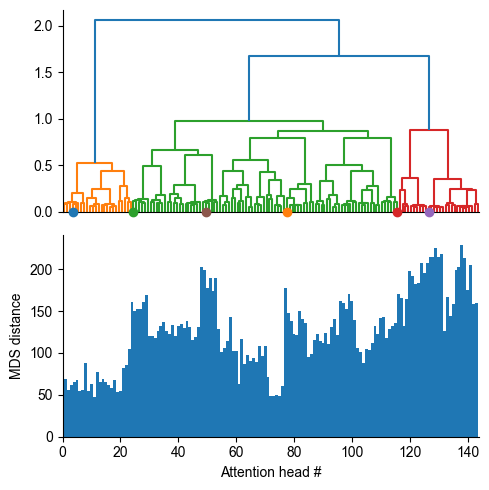

In [17]:
fig, axes = plt.subplots(2,1, figsize=(5, 5))
#plt.title("DINO ViT-8; 2nd model, 8th layer")
dn = dendrogram(Z, no_labels=True, ax=axes[0])#, p=5), truncate_mode="level")#, labels=np.arange(1,7))
for i in range(6):
    axes[0].scatter(leaf_pos[head_ind_dend][i], 0, zorder=10, clip_on=False)
#plt.scatter(leaf_pos[head_ind_dend], np.zeros(6), zorder=10, c=np.arange(6), clip_on=False, cmap="Set1")
#plt.xlabel("attention head #")
axes[1].bar(np.arange(len(leaves)), mds_dist_concat[leaves], width=1)
axes[1].set_xlim(0, 144)
axes[1].set_ylabel("MDS distance")
axes[1].set_xlabel("Attention head #")
plt.tight_layout()

In [18]:
Z = linkage(dist_mat_mean, 'ward', optimal_ordering=True)

In [19]:
cophenet(Z, dist_mat_mean)

(0.6847648988654281,
 array([2.06675632, 2.06675632, 2.06675632, ..., 1.6781797 , 0.97316212,
        1.6781797 ]))

In [20]:
labels = fcluster(Z, 3, criterion='maxclust')

In [21]:
print(labels)

[1 3 2 2 2 3 1 3 2 2 2 3 1 3 2 2 2 3 1 3 2 2 2 3 1 3 2 2 2 3 1 3 2 2 2 3 1
 2 2 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 3 2
 2 2 2 2 3 1 1 2 2 2 2 2 1 2 2 2 3 2 1 2 2 2 2 2 2 1 2 2 3 2 2 1 2 2 1 2 2
 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 1 2 2 2 3 2 2 2 1 2 3 2 2 2 1 2 3 2]


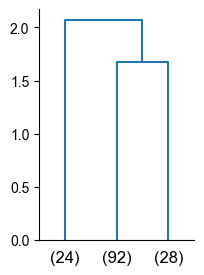

In [22]:
fig = plt.figure(figsize=(2, 3))
#dn = dendrogram(Z, no_labels=True)#, p=3, truncate_mode="lastp")
dn = dendrogram(Z, p=3, truncate_mode="lastp")
#plt.scatter([5,15,25], np.zeros(3), zorder=10, clip_on=False)

In [23]:
from sklearn.manifold import MDS

In [24]:
X = squareform(dist_mat_mean)

In [25]:
embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', random_state=2)
X_transformed = embedding.fit_transform(X)

In [26]:
cmap = plt.get_cmap("Set2")

In [27]:
from scipy.cluster.hierarchy import set_link_color_palette

In [28]:
gidx = np.linspace(0, 144, 5).astype(int)

In [29]:
cmap = sns.color_palette("colorblind")

In [30]:
layer_labels = ["7/8", "8/8", "9/12", "10/12"]

In [31]:
"""fig, axes = plt.subplots(1,4, figsize=(9, 2.5), width_ratios=[0.5, 1, 1, 1.2])
set_link_color_palette(["tab:red","tab:purple","tab:blue"])#([cmap(7), cmap(0), cmap(1), cmap(2)])
dn = dendrogram(Z, no_labels=True, ax=axes[0], above_threshold_color="tab:gray")
axes[0].axhline(0.7*max(Z[:,2]), linestyle="--", color="k", alpha=0.5)
#axes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=cmap(labels[leaves]-1))
axes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=dn['leaves_color_list'])

for i in range(4):
    axes[2].scatter(X_transformed[gidx[i]:gidx[i+1], 0], X_transformed[gidx[i]:gidx[i+1], 1], color=cmap[i], label=layer_labels[i])
axes[2].legend()
sc = axes[3].scatter(X_transformed[:, 0], X_transformed[:, 1], c=mds_dist_concat)
plt.colorbar(sc, label='MDS distance')
axes[1].set_title("Hierarchical clustering")
axes[2].set_title("ViT layer/total layer")
axes[3].set_title("MDS distance")
axes[0].set_ylabel("Cluster distance")
axes[1].set_ylabel("MDS 2")
axes[2].set_xlabel("MDS 1")
#axes[2].sharey(axes[1])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
for i in range(4):
    axes[i].minorticks_on()

#axes[2].set_yticks([])
fig.tight_layout()
fig.savefig("../figures/head_grouping.svg", dpi=300, bbox_inches="tight")
"""

'fig, axes = plt.subplots(1,4, figsize=(9, 2.5), width_ratios=[0.5, 1, 1, 1.2])\nset_link_color_palette(["tab:red","tab:purple","tab:blue"])#([cmap(7), cmap(0), cmap(1), cmap(2)])\ndn = dendrogram(Z, no_labels=True, ax=axes[0], above_threshold_color="tab:gray")\naxes[0].axhline(0.7*max(Z[:,2]), linestyle="--", color="k", alpha=0.5)\n#axes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=cmap(labels[leaves]-1))\naxes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=dn[\'leaves_color_list\'])\n\nfor i in range(4):\n    axes[2].scatter(X_transformed[gidx[i]:gidx[i+1], 0], X_transformed[gidx[i]:gidx[i+1], 1], color=cmap[i], label=layer_labels[i])\naxes[2].legend()\nsc = axes[3].scatter(X_transformed[:, 0], X_transformed[:, 1], c=mds_dist_concat)\nplt.colorbar(sc, label=\'MDS distance\')\naxes[1].set_title("Hierarchical clustering")\naxes[2].set_title("ViT layer/total layer")\naxes[3].set_title("MDS distance")\naxes[0].set_ylabel("Cluster distance")\naxes[1].

In [32]:
import pandas as pd

In [33]:
df_mds = pd.DataFrame(np.c_[mds_dist_concat[leaves], labels[leaves].astype(int)], columns=["mds_dist", "label"])

In [34]:
df_mds

,mds_dist,label
0,66.335506,1.0
1,69.508063,1.0
2,56.011912,1.0
3,62.178611,1.0
4,65.828025,1.0
...,...,...
139,213.325365,3.0
140,174.706219,3.0
141,205.303094,3.0
142,159.021695,3.0


In [35]:
cols = ["#DC267F", "#648FFF", "#FFB000"]#["#66C2A5","#FC8D62","#8DA0CB"]
pal = {i+1: cols[i] for i in range(3)}
#pal = {1.0: "tab:red", 2.0: "tab:purple", 3.0: "tab:blue"}

In [36]:
pal

{1: '#DC267F', 2: '#648FFF', 3: '#FFB000'}

In [37]:
labels2 = np.load("../results/attn_best_label_N2010.npy")

In [38]:
(labels == 3) == (labels2 == 2)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [39]:
cols = ["#56B4E9", "#FFB000", "#DC267F"]#"#DC267F", "#648FFF", "#FFB000"]
pal = {i+1: cols[i] for i in range(3)}

In [40]:
pal

{1: '#56B4E9', 2: '#FFB000', 3: '#DC267F'}

In [41]:
dfs = pd.DataFrame(np.c_[X_transformed, labels], columns=["x", "y", "label"])

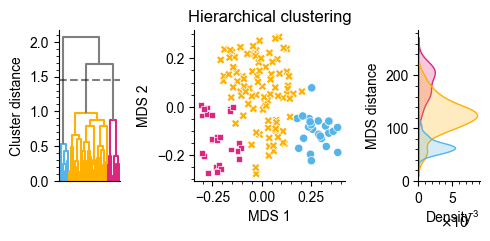

In [42]:
fig, axes = plt.subplots(1,3, figsize=(5, 2.5), width_ratios=[0.4, 1, 0.4])
set_link_color_palette(cols)#([cmap(7), cmap(0), cmap(1), cmap(2)])
dn = dendrogram(Z, no_labels=True, ax=axes[0], above_threshold_color="tab:gray")
axes[0].axhline(0.7*max(Z[:,2]), linestyle="--", color="k", alpha=0.5)
#axes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=cmap(labels[leaves]-1))
#axes[1].scatter(X_transformed[leaves, 0], X_transformed[leaves, 1], c=dn['leaves_color_list'], alpha=0.8)
sns.scatterplot(data=dfs, x="x", y="y", hue="label", ax=axes[1], palette=pal, style="label", legend=False)
axes[1].set_title("Hierarchical clustering")
axes[0].set_ylabel("Cluster distance")
axes[1].set_ylabel("MDS 2")
axes[1].set_xlabel("MDS 1")
axes[1].set_box_aspect(1)
for i in range(3):
    axes[i].minorticks_on()
sns.kdeplot(data=df_mds, y="mds_dist", hue="label", ax=axes[2], fill=True, palette=pal)
axes[2].set_ylabel("MDS distance")
axes[2].set_ylim(0, )
axes[2].set_xlim(0, )
axes[2].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, -3),  # x10^(-3) 指定
    useMathText=True,  # x10^N
)
#axes[2].set_yticks([])
axes[2].get_legend().remove()
fig.tight_layout()
fig.savefig("../figures/head_grouping.svg", dpi=300, bbox_inches="tight")

In [43]:
gleaves = []
for i in range(1, 4):
    lidx = np.where(labels == i)[0]
    print(i, np.sum(lidx < 72), np.sum(lidx >= 72))

1 12 12
2 42 50
3 18 10
